In [1]:
from docplex.mp.model import Model
import numpy as np
from plot import plot_tsp
from scipy.spatial.distance import cdist

In [2]:
num_cities = 100

V = list(range(num_cities))
E = [(i, j) for i in V for j in V if i != j]

X = np.random.default_rng(0).random((len(V), 2))

# compute euclidean distance matrix
c = cdist(X, X)
c.shape

(100, 100)

In [3]:
def find_subtours(edges):
    edges = dict(edges)
    remaining = list(range(len(edges)))
    all_subtours = []
    while len(remaining) > 0:
        subtour = []
        current = remaining[0]
        while True:
            if current not in remaining:
                break
            subtour.append(current)
            remaining.remove(current)
            current = edges.get(current, None)
        all_subtours.append(subtour)
    return all_subtours

In [4]:
model = Model('TSP_DFJ')

x = model.binary_var_dict(E, name='x')

# add in and out degree constraints
model.add_constraints(model.sum(x[i, j] for i in V if i != j) == 1 for j in V)
model.add_constraints(model.sum(x[i, j] for j in V if i != j) == 1 for i in V)

# objective function
model.minimize(model.sum(c[i, j] * x[i, j] for i in V for j in V if i != j))

# solve the model
while True:
    solution = model.solve(log_output=False)
    edges = list(solution.get_value_dict(x, keep_zeros=False).keys())
    subtours = find_subtours(edges)
    
    if len(subtours) > 1:
        print(f'Found unfeasible solution with {len(subtours)} subtours')
        for subtour in subtours:
            model.add_constraint(model.sum(x[i, j] for i in subtour for j in subtour if i != j) <= len(subtour) - 1)
    else:
        print('Optimal solution found')
        break

Found unfeasible solution with 44 subtours
Found unfeasible solution with 13 subtours
Found unfeasible solution with 4 subtours
Found unfeasible solution with 5 subtours
Found unfeasible solution with 5 subtours
Found unfeasible solution with 6 subtours
Optimal solution found


Tour cost: 7.871863269323004


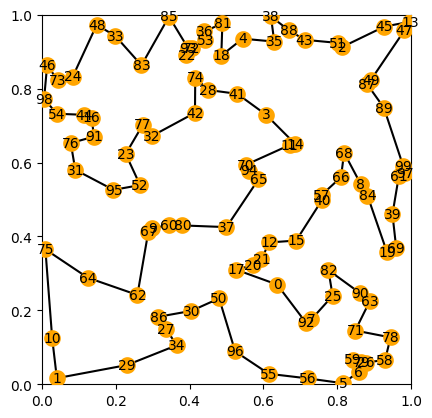

In [5]:
sol_edges = list(solution.get_value_dict(x, keep_zeros=False).keys())

print(f'Tour cost: {solution.objective_value}')

plot_tsp(X, sol_edges, dpi=100)